In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import partial
sns.set_style("whitegrid")

In [107]:
RESULTSDIR="/data1/s1620444/results"
PLOTSDIR="/data1/s1620444/plots"

In [84]:
# get scores per trial and save to csv
results_cerrado=pd.read_csv(f"{RESULTSDIR}/autosr/cerrado_100_trials.csv",header=0)
results_sent_nicfi=pd.read_csv(F"{RESULTSDIR}/autosr/sent_nicfi_50_trials.csv",header=0)


In [85]:
def get_best_psnr(df,x):
    """ Get best PSNR score up to current trial"""
    trial=x.trial
    run=x.run
    return df.loc[(df.run==run) & (df.trial <=trial)]["val_psnr"].max()



In [93]:
def get_mean_of_elitist(results):
    # first calculate elitist psnr
    get_best=partial(get_best_psnr, results)

    results_copy=results.copy()
    results_copy["elitist_psnr"]=results_copy.apply(get_best,axis=1)

    # calculate length of longest run
    max_trials=results_copy.trial.max()

    # make sure each run has equal number of trials
    # by repeating last result until max_trials is reached
    for run in range(5):
        run_max_trial=results_copy.loc[results_copy.run==run].trial.max()
        for t in range(run_max_trial+1, max_trials+1):
            results_copy=results_copy.append(results_copy.loc[(results_copy.run==run) & (results_copy.trial==run_max_trial)].assign(**{'trial':t}),ignore_index=True)

    # calculate the means of elitist scores
    elitist_means=results_copy.groupby("trial")["elitist_psnr"].mean()

    # calculate 0.25 and 0.75 quantile
    first_quantile=results_copy.groupby("trial")["elitist_psnr"].quantile(.25)
    third_quantile=results_copy.groupby("trial")["elitist_psnr"].quantile(.75)

    return pd.DataFrame.from_dict({"mean_psnr": elitist_means,"lower_q":first_quantile,"upper_q":third_quantile})

In [103]:
def plot_elitist(results,ax,xlim,name):

    elitist_scores=get_mean_of_elitist(results)
    ax.plot(elitist_scores.index.to_numpy(),elitist_scores["mean_psnr"].to_numpy())
    ax.fill_between(elitist_scores.index.to_numpy(),elitist_scores["lower_q"].to_numpy(), elitist_scores["upper_q"].to_numpy(),alpha=0.5)
    ax.set_title(name)
    ax.set_xlim(0,xlim)
    ax.set_xlabel("Trials")
    ax.set_xticks(range(0,xlim,5))
    if name=="SENT-NICFI":
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.set_ylabel("PSNR",rotation=270,labelpad=20)
    else:
        ax.set_ylabel("PSNR")

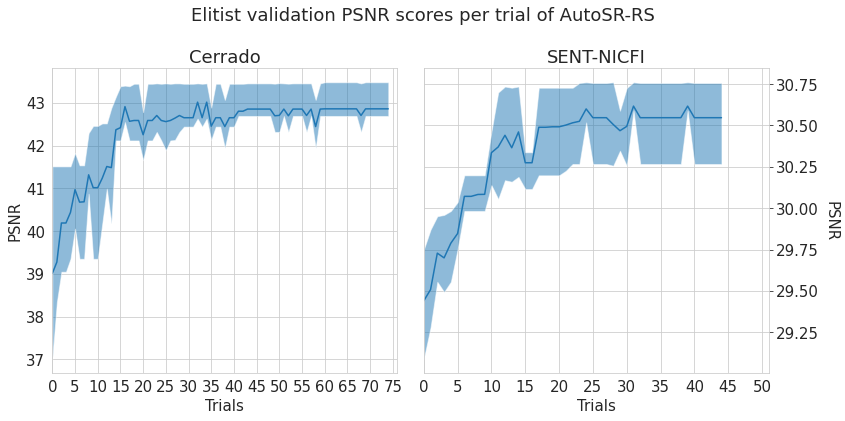

In [108]:
plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(1,2,figsize=(12,6))

plot_elitist(results_cerrado, ax[0], 76,"Cerrado")
plot_elitist(results_sent_nicfi, ax[1], 51,"SENT-NICFI")

plt.suptitle("Elitist validation PSNR scores per trial of AutoSR-RS")
plt.tight_layout()
plt.savefig(f"{PLOTSDIR}/elitist_val_psnr.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

<h2> 